<a href="https://colab.research.google.com/github/rachit-shah/automated-learning-and-data-analysis/blob/master/hw2q5%20(Naive%20Bayes%20and%20Decision%20Tree%20from%20Scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
      

In [0]:
!pip install anytree
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


#Question 5 [ Naive Bayes + Decision Tree]

####(20 points) [Na¨ıve Bayes + Decision Tree] [Ruth Okoilu] For this exercise, use the provided ‘hw2q5.csv’ which contains 24 data points. It has six attributes: each data point will be referred to using the first column ”Id” and we will use columns 2-5 to predict the final column ”Class” (whether or not a patient should have contact lens).

###(a) (15 points) Compare the performance of two classifiers: Na¨ıve Bayes (NB) vs. Decision Tree (DT) using 5-fold cross-validation (CV) and report their 5-fold CV accuracy. For the ith fold, the testing dataset is composed of all the data points whose (Id mod 5 = i − 1). Follow the lecture’s code to build your decision trees except that multiple-way splitting is allowed and use Information Gain (IG) to select the best attribute. In the case of ties, break ties in favor of the leftmost feature. For each fold, show the induced Na¨ıve Bayes and DT models.

In [0]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import operator
from collections import Counter, defaultdict
#display image from file
from IPython.display import Image
#visualize tree using graphviz
from anytree import Node
from anytree.exporter import DotExporter
#Model Evaluation
from sklearn.metrics import confusion_matrix,accuracy_score
import itertools

In [0]:
#Read csv file and assign proper labels to the columns
df = pd.read_csv('hw2q5.csv')
df

,Id,patient age,spectacle prescription,astigmatic,tear production rate,Class
0,1,young,myope,no,reduced,No
1,2,young,myope,no,normal,Yes
2,3,young,myope,yes,reduced,No
3,4,young,myope,yes,normal,Yes
4,5,young,hypermetrope,no,reduced,No
5,6,young,hypermetrope,no,normal,Yes
6,7,young,hypermetrope,yes,reduced,No
7,8,young,hypermetrope,yes,normal,Yes
8,9,pre-presbyopic,myope,no,reduced,No
9,10,pre-presbyopic,myope,no,normal,Yes


In [0]:
#A n-ary Tree Structure which is trained on train set and used for
#predicting new datapoints
class TreeNode(object):
    def __init__(self, data):
        self.data = data
        self.children = []  #list of children
        self.edges = []     #their corresponding edges

    #function to add child to current node
    def add_child(self, obj,obj2):   
        self.children.append(obj)
        self.edges.append(obj2)

##Build Decision Tree Recursively

In [0]:

# Function to recursively build tree by selecting the best attribute at a split 
# using ID3 and then recurse for the left and right child. It has the 
# following parameters:
# 1. treeNode - node corresponding to TreeNode structure to predict
# 2. node - the tree node at the current level either derived from the 
#    left or right child of the parent in prev level for graphviz
# 3. data - the DataFrame at the current level after removing previous splits
# 4. level - the current level/depth of the tree
# 5. parent (default=None) - the parent node of the current node
countNode=0
def buildTree(treeNode,node,data,level,parent=None):
  Att = list(data.columns) #List the Attributes left at the given level
  #Remove Class and Id as it's not a feature
  Att.remove("Class")
  Att.remove("Id")
  #Count of nodes added to all nodes because graphviz merges 2 nodes with
  #same name which would be a problem for left and right subtree calcs
  global countNode
  countNode = countNode + 1
  #If homogeneous data at Class for current node value, reached leaf node
  if (same(data)):
    #Assign the most frequent(mode) of the Class to the leaf node result
    resultClass = data.Class.mode()[0]
    #For printing result node
    print("All classes same")
    print("ResultClass for child node of '",parent,"' = ",resultClass)
    #assign the value to the node for tree visualization using graphviz
    node.name = resultClass+" ("+str(countNode)+")"
    #assign the value to the n-ary Tree
    treeNode.data = resultClass
    printTree()   #Print intermediate tree
   
  #Same as previous, reached leaf node, except because there's no attributes
  #left to split on, may have heterogeneous data
  elif not Att:
    #Assign the most frequent(mode) of the Class to the leaf node result
    resultClass = data.Class.mode()[0]
    #assign the value to the node for tree visualization using graphviz
    node.name = resultClass+" ("+str(countNode)+")"
    treeNode.data = resultClass
    print("No attributes left")
    print("ResultClass for child node of '",parent,"' = ",resultClass)
    printTree()
  #If haven't reached leaf, then for internal nodes check for which attribute 
  #to split on using ID3
  else:
    #a is the best attribute selected and if the attribute is continuous, 
    #it will also return the split (the number) where to split
    a, split = bestAttribute(data,Att,level,parent)
    node.name = a +" ("+str(countNode)+")"  #Assign value to graphviz tree
    treeNode.data = a                       #Assign value to n-ary Tree
    print("\n")
    print("Best Attribute for node of parent ",parent," for Level ",level," is ",a)
    if split:
      print("with split=",str(split))
    printTree()
    #recurse for left and right sub-trees. Create an empty node for both left
    #and right childs with a temporary "None" name which will be assigned to 
    #them at lower depths. Parent is assigned to current node for the child and
    #edge value of tree is the attribute value of parent for each child. 
    #We also select the rows corresponding to the attribute value attVals[i] and
    #drop the current node's column.
    #The edge values are different for categorical or continuous values
    if(isCategorical(a)):
      attVals = list(data[a].unique())
      for x in attVals:
        child = TreeNode("None")
        treeNode.add_child(child,x)
        buildTree(child,Node("None", parent=node, edge=x),data[data[a]==x].drop(columns=a),level+1,a)
    #Else for continuous attribute
    else:
      leftchild = TreeNode("None")
      treeNode.add_child(leftchild,"<"+str(split))
      buildTree(leftchild,Node("None", parent=node, edge="<"+str(split)),data[data[a]<split].drop(columns=a),level+1,a)
      rightchild = TreeNode("None")
      treeNode.add_child(rightchild,">="+str(split))
      buildTree(rightchild,Node("None", parent=node, edge=">="+str(split)),data[data[a]>=split].drop(columns=a),level+1,a)

#Function for finding whether the Class column is homogeneous for given level
def same(data):
  if len(data.Class.unique()) == 1:
    return True
  else:
    return False


##Suppport Functions for Best Attribute Calculations

In [0]:
#Find Probability for givenClass w/o givenValue. For e.g., P(Color) for prob.
#corresponding to class values and P(Color=Red) for prob. corresponding to a 
#specific value of the attribute
def probability(data,givenClass,givenValue,overall=False):
  #for P(Color)
  if overall:
    if givenValue==None:
        valueCounts = data[givenClass].value_counts() #find count of unique vals
        if(len(valueCounts)==1):   #if homogeneous, prob = 1
          prob = 1
        else:                      #else p/p+n
          prob = valueCounts[0]/(valueCounts[0]+valueCounts[1])
        return prob
    else:
        valueCounts = data[data[givenClass]==givenValue].size #find count of unique vals
        return valueCounts/data.size
  #for P(Color=Red)
  else:
    data = data[data[givenClass] == givenValue] #subset with value of attribute
    valueCounts = data.Class.value_counts() #find unique counts for subset
    if(len(valueCounts)==1):               #if homogeneous, prob = 1
      prob = 1
    else:                                  #else p/p+n
      prob = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    return prob

#Function to determine if a function is categorical or continuous from its dtype
def isCategorical(a):
  numeric = ["int32","int64","float32","float64"]
  categorical = ["object","O"]
  if df[a].dtype in numeric:
    return False  #if numeric, continuous
  else:
    return True   #else, categorical

#Probability function for continuous attributes
#same as categorical, except split is done < and >=
def probabilityContinuous(data,givenClass,split,ofSplit = False):
  if not ofSplit:
    return len(data[data[givenClass]<split])/len(data)
  else:
    data1 = data[data[givenClass] < split]
    data2 = data[data[givenClass] >= split]
    valueCounts = data1.Class.value_counts()
    #print("1 ",str(split)+"  ", valueCounts)
    if(len(valueCounts)==1):
      prob1 = 1
    else:
      prob1 = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    valueCounts = data2.Class.value_counts()
    #print("2 ",str(split)+"  ",valueCounts)
    if(len(valueCounts)==1):
      prob2 = 1
    else:
      prob2 = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    return prob1,prob2   #return prob for < and >=


##Best Attribute Calculation using ID3/Entropy

In [0]:
#H(X) = -Σ(p(X=c)*log2(p(X=c))
def entropy(prob):
  #print(prob)
  if(prob!=0 and prob!=1):
    return -(prob*math.log2(prob)+(1-prob)*math.log2(1-prob))
  else:
    return 0  #for homogeneous, entropy is 0
  
#Function to find the best attribute and the split value for given level
#using ID3/Entropy Calculations
def bestAttribute(data,Att,level,parent):
  print("LEVEL",str(level)," PARENT",parent)
  computation = ""      #string for printing computations
  gains = []            #list of information gains for all attributes
  probClass = probability(data,"Class",None,True) #P(Y) - Probability of Class
  classEntropy = entropy(probClass)          #H(Y) - Entropy of Class
  computation += "H(Class)="+str(classEntropy)+"\n"
  continuousSplits = {}  #dict of splits for all continuous attributes
  #Now, for each attribute we will calculate, H(Y|X)= Σ P(X=i)*H(X=i|Y) where
  # H(X=i|Y) = -Σ(p(X=c)*log2(P(X=c)))
  for x in Att:
    componentEntropy = 0
    # for categorical values
    if isCategorical(x):
      attVals = list(data[x].unique())  #list all unique values of attribute
      for y in attVals:
        probX = probability(data,x,y,True)  #P(X)
        probValue = probability(data,x,y)  #p(X=c)
        subCompEntropy = entropy(probValue)  #H(X=c)
        computation += "H(Class|"+x+"='"+y+"')="+str(subCompEntropy)+"\n"
        componentEntropy += probX*subCompEntropy   #H(Y|X)
      gains.append(classEntropy-componentEntropy)  #Append to list
      computation += "Entropy(Class|"+x+")="+str(componentEntropy)+"\n"
      computation += "Gain(Class|"+x+")="+str(classEntropy-componentEntropy)+"\n"
    #else for continuous attribute, determine where to split iteratively and 
    #take the split corresponding to maximum gain
    else:
      splitVal,splitGain = determineSplit(data,classEntropy,x)
      continuousSplits[x] = splitVal   #Add to dictionary of continuous att
      gains.append(splitGain)    #Append gain
  print(computation)
  #Now, select the attribute which gives the maximum information gain and return
  #it. If continuous also return the split value
  bestAttr = data.columns[gains.index(max(gains))+1]
  if(isCategorical(bestAttr)):
    return bestAttr, None
  else:
    return bestAttr, continuousSplits[bestAttr]
  
#Function to determine split for continuous attributes. Done by iterating over
#all possible splits and returning the one with maximum gain. H(X<i)
def determineSplit(data,classEntropy,givenClass):
  computation = ""
  #Take subset as we don't need other attributes and sort them according to vals
  data = data[[givenClass,"Class"]]
  data = data.sort_values(givenClass)
  data = data.reset_index(drop=True)
  gains = {}
  arr = list(data[givenClass].unique())[1:]   #unique values, iterate from 1
  #arr.append(arr[len(arr)-1]+1)
  #iterate for each possible split H(X<arr[i])
  for x in arr:
    #Same calculations as before
    #prob for continuous att
    probX = probabilityContinuous(data,givenClass,x) 
    lessThanProb, moreThanProb = probabilityContinuous(data,givenClass,x,True)
    lessThanEntropy = entropy(lessThanProb)
    computation += "Entropy(Class|"+givenClass+"<"+str(x)+")="+str(lessThanEntropy)+"\n"
    moreThanEntropy = entropy(moreThanProb)
    computation += "Entropy(Class|"+givenClass+">="+str(x)+")="+str(moreThanEntropy)+"\n"
    gain = classEntropy - ((probX*lessThanEntropy)+((1-probX)*moreThanEntropy))
    computation += "Gain(Class|"+givenClass+"="+str(x)+")="+str(gain)+"\n"
    gains[x]=gain
  split, maxgain = max(gains.items(), key=operator.itemgetter(1))
  computation += "Maximum gain is:"+str(maxgain)
  computation += " corresponding to split "+str(split)+"\n"
  print(computation)
  return split,maxgain 

##Visualize tree using graphviz which uses dot language. anytree library helps create dot code

In [0]:
#how to display node values
def nodenamefunc(node):
    return '%s:%s' % (node.name, node.depth)
#how to display edge values
def edgeattrfunc(node, child):
  return 'label="%s"' % (child.edge)
#how edge values represented in dot code
def edgetypefunc(node, child):
  return '--'
#export dot code to a png image and display it
def printTree():
  DotExporter(root, graph="graph",nodenamefunc=nodenamefunc,nodeattrfunc=lambda node: "shape=box",edgeattrfunc=edgeattrfunc,edgetypefunc=edgetypefunc).to_picture("graph.png")
  display(Image("graph.png"))

##Predict for new data

In [0]:
#Function to predict new data points. This functions traverses the created n-ary
#tree for edges corresponding to its value until it reaches a leaf node
def predict(treeRoot,row):
  temp = treeRoot   #temporary variable for root
  predictedClass = None
  while(temp.children):    #while there exists children for current node
    nodevalue = row[temp.data]   #Get nodevalue corresponding to root of tree
    try:
      selectedge = temp.edges.index(nodevalue)   #Get corresponding edge
    except:
      selectedge = 0
      
    temp = temp.children[selectedge] #Get corresponding child and make it current
    #If reached leaf, then break and print output.
    predictedClass = temp.data
    if predictedClass in ["No","Yes"]:
      break
    
  return predictedClass
    

In [0]:
#Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##5-Fold Cross Validation  for Decision Tree

*****************************************FOLD 1 ************************************************

LEVEL 0  PARENT None
H(Class)=0.9340680553754911
H(Class|patient age='young')=0.9852281360342515
H(Class|patient age='pre-presbyopic')=0.9182958340544896
H(Class|patient age='presbyopic')=0.5916727785823275
Entropy(Class|patient age)=0.8274040703321495
Gain(Class|patient age)=0.10666398504334162
H(Class|spectacle prescription='myope')=0.8812908992306927
H(Class|spectacle prescription='hypermetrope')=0.9709505944546686
Entropy(Class|spectacle prescription)=0.9261207468426806
Gain(Class|spectacle prescription)=0.007947308532810449
H(Class|astigmatic='no')=0.9709505944546686
H(Class|astigmatic='yes')=0.8812908992306927
Entropy(Class|astigmatic)=0.9261207468426806
Gain(Class|astigmatic)=0.007947308532810449
H(Class|tear production rate='reduced')=0
H(Class|tear production rate='normal')=0.8812908992306927
Entropy(Class|tear production rate)=0.44064544961534635
Gain(Class|tear production rate)=

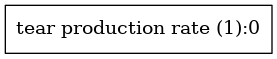

All classes same
ResultClass for child node of ' tear production rate ' =  No


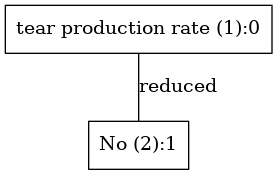

LEVEL 1  PARENT tear production rate
H(Class)=0.8812908992306927
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0.9182958340544896
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.5509775004326937
Gain(Class|patient age)=0.33031339879799904
H(Class|spectacle prescription='myope')=0.8112781244591328
H(Class|spectacle prescription='hypermetrope')=0.9182958340544896
Entropy(Class|spectacle prescription)=0.8754887502163469
Gain(Class|spectacle prescription)=0.0058021490143458365
H(Class|astigmatic='no')=0.7219280948873623
H(Class|astigmatic='yes')=0.9709505944546686
Entropy(Class|astigmatic)=0.8464393446710154
Gain(Class|astigmatic)=0.034851554559677256



Best Attribute for node of parent  tear production rate  for Level  1  is  patient age


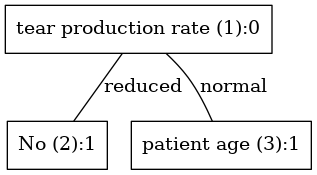

All classes same
ResultClass for child node of ' patient age ' =  Yes


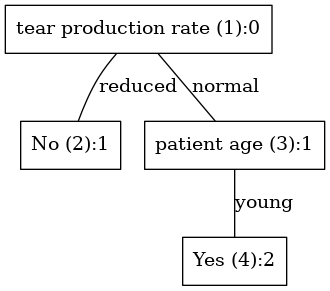

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=0.6666666666666666
Gain(Class|spectacle prescription)=0.2516291673878229
H(Class|astigmatic='yes')=1.0
H(Class|astigmatic='no')=0
Entropy(Class|astigmatic)=0.6666666666666666
Gain(Class|astigmatic)=0.2516291673878229



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


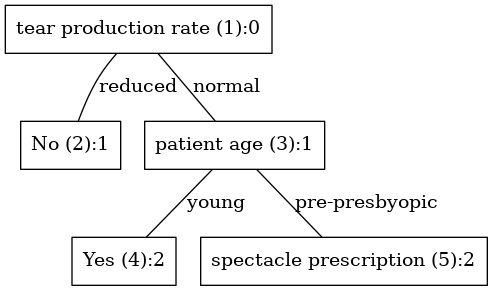

All classes same
ResultClass for child node of ' spectacle prescription ' =  Yes


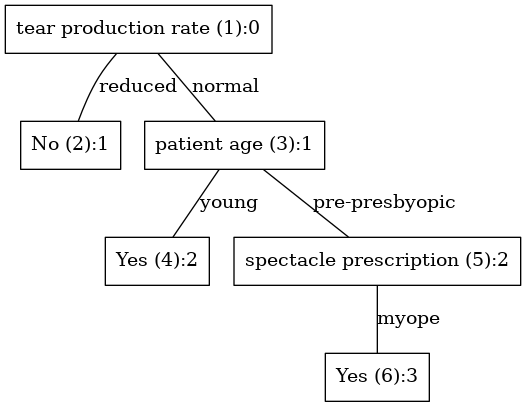

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


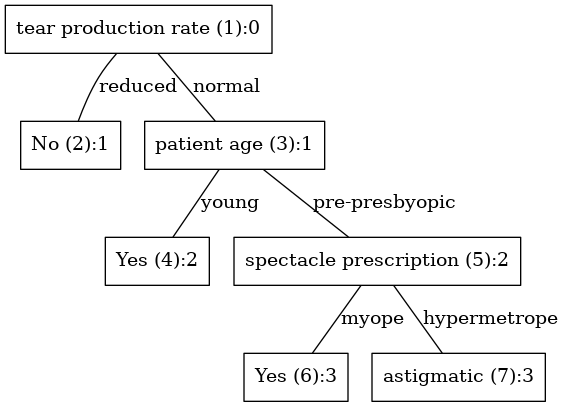

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


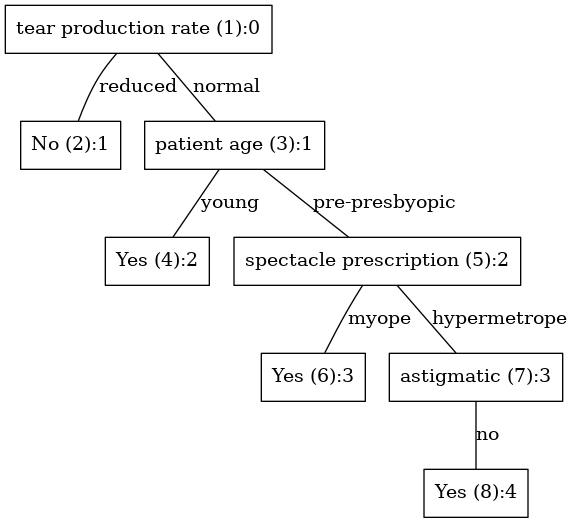

All classes same
ResultClass for child node of ' astigmatic ' =  No


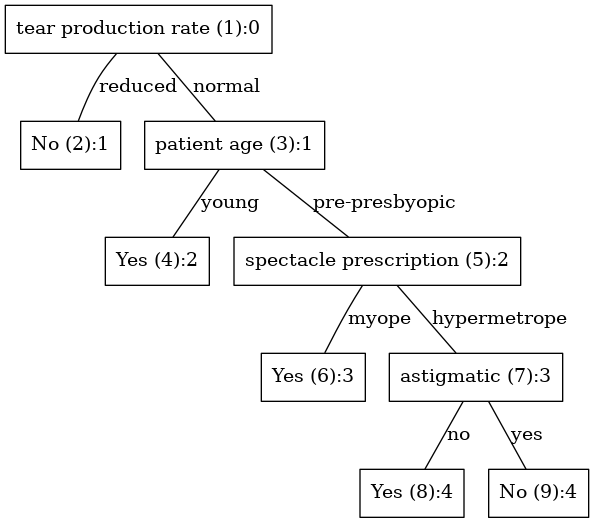

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=0.6666666666666666
Gain(Class|spectacle prescription)=0.2516291673878229
H(Class|astigmatic='no')=1.0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.6666666666666666
Gain(Class|astigmatic)=0.2516291673878229



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


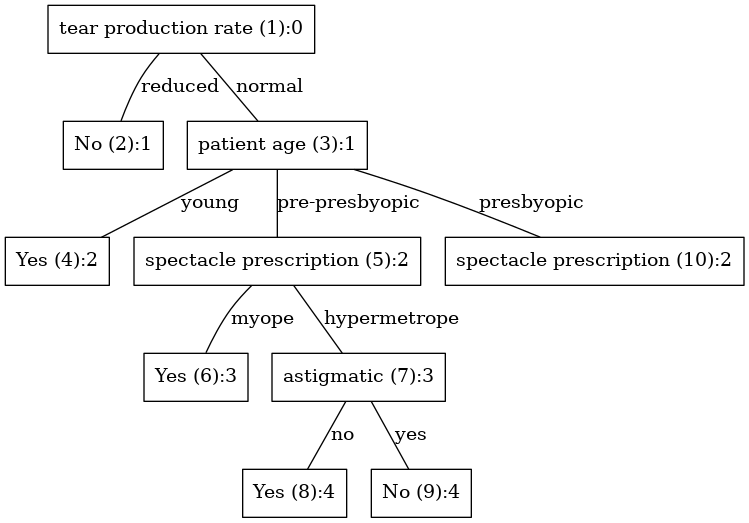

All classes same
ResultClass for child node of ' spectacle prescription ' =  No


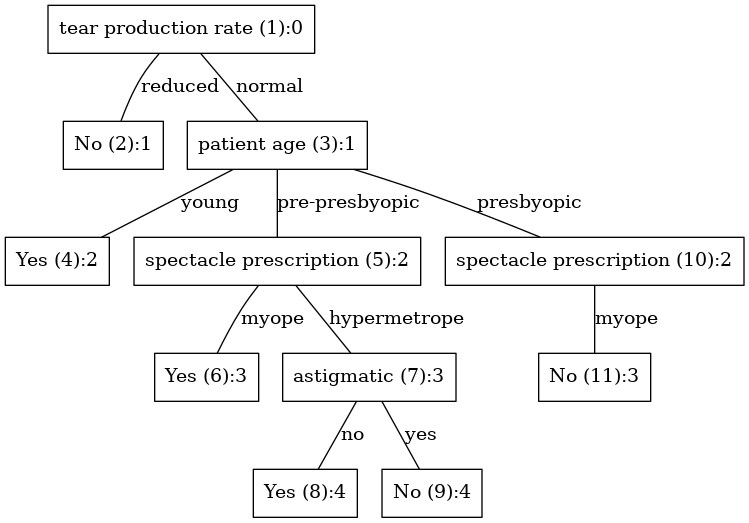

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


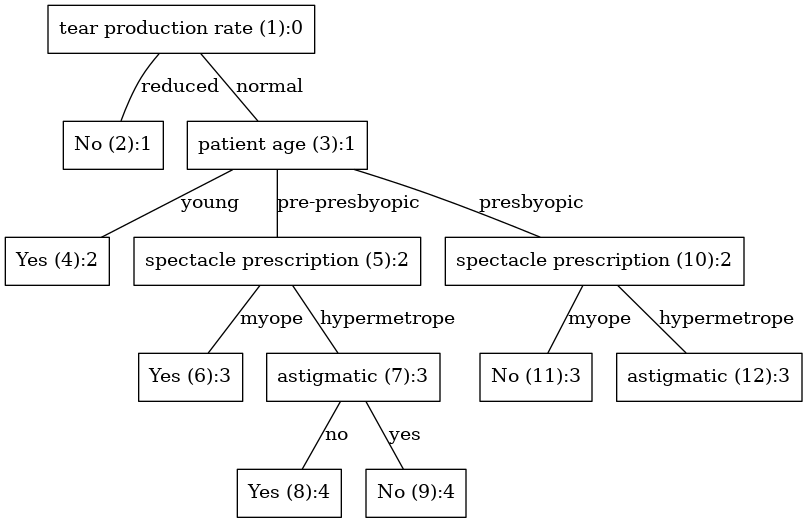

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


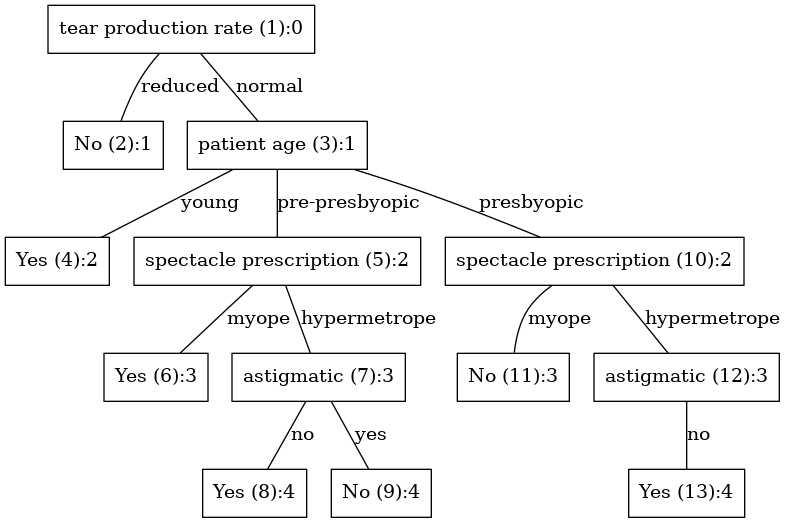

All classes same
ResultClass for child node of ' astigmatic ' =  No


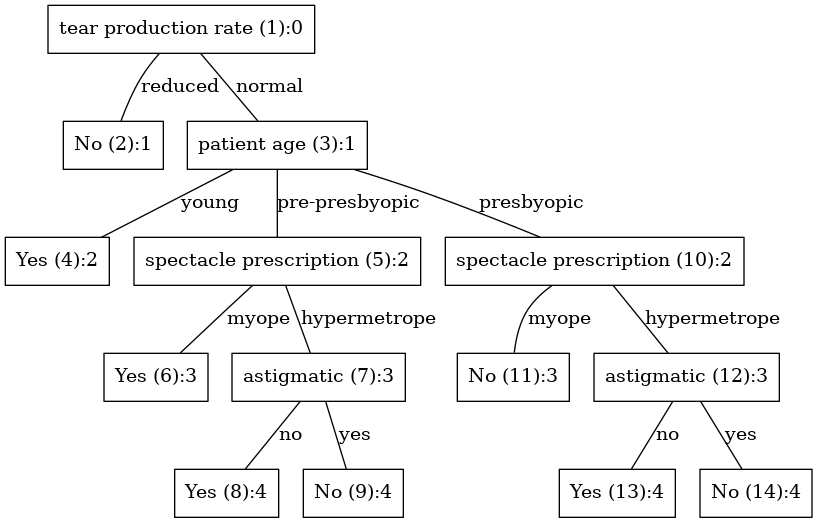

Confusion matrix, without normalization
[[2 0]
 [1 1]]
*****************************************FOLD 2 ************************************************

LEVEL 0  PARENT None
H(Class)=0.9819407868640976
H(Class|patient age='young')=1.0
H(Class|patient age='pre-presbyopic')=1.0
H(Class|patient age='presbyopic')=0.863120568566631
Entropy(Class|patient age)=0.9495707357877061
Gain(Class|patient age)=0.03237005107639146
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=0.9182958340544896
Entropy(Class|spectacle prescription)=0.9612980266573897
Gain(Class|spectacle prescription)=0.020642760206707855
H(Class|astigmatic='no')=0.9910760598382222
H(Class|astigmatic='yes')=0.9709505944546686
Entropy(Class|astigmatic)=0.9804837096363519
Gain(Class|astigmatic)=0.0014570772277456845
H(Class|tear production rate='normal')=0.7219280948873623
H(Class|tear production rate='reduced')=0
Entropy(Class|tear production rate)=0.3799621552038749
Gain(Class|tear producti

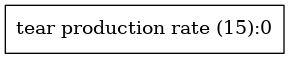

LEVEL 1  PARENT tear production rate
H(Class)=0.7219280948873623
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0
H(Class|patient age='presbyopic')=1.0
Entropy(Class|patient age)=0.4
Gain(Class|patient age)=0.3219280948873623
H(Class|spectacle prescription='myope')=0.6500224216483541
H(Class|spectacle prescription='hypermetrope')=0.8112781244591328
Entropy(Class|spectacle prescription)=0.7145247027726656
Gain(Class|spectacle prescription)=0.007403392114696761
H(Class|astigmatic='no')=0.7219280948873623
H(Class|astigmatic='yes')=0.7219280948873623
Entropy(Class|astigmatic)=0.7219280948873623
Gain(Class|astigmatic)=0.0



Best Attribute for node of parent  tear production rate  for Level  1  is  patient age


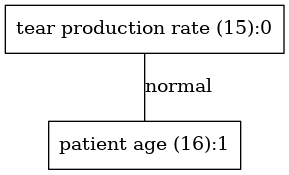

All classes same
ResultClass for child node of ' patient age ' =  Yes


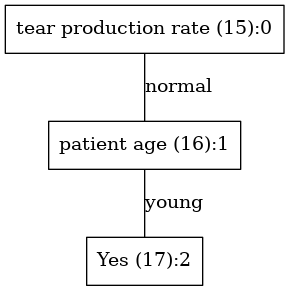

All classes same
ResultClass for child node of ' patient age ' =  Yes


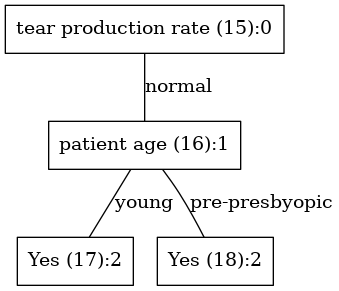

LEVEL 2  PARENT patient age
H(Class)=1.0
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=1.0
Gain(Class|spectacle prescription)=0.0
H(Class|astigmatic='no')=1.0
H(Class|astigmatic='yes')=1.0
Entropy(Class|astigmatic)=1.0
Gain(Class|astigmatic)=0.0



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


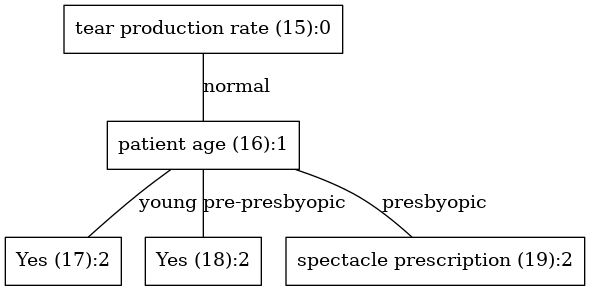

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


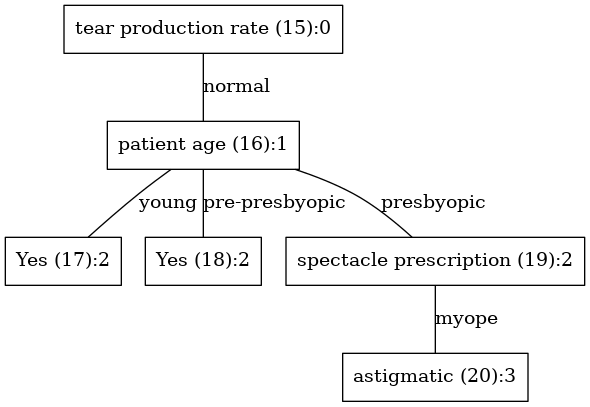

All classes same
ResultClass for child node of ' astigmatic ' =  No


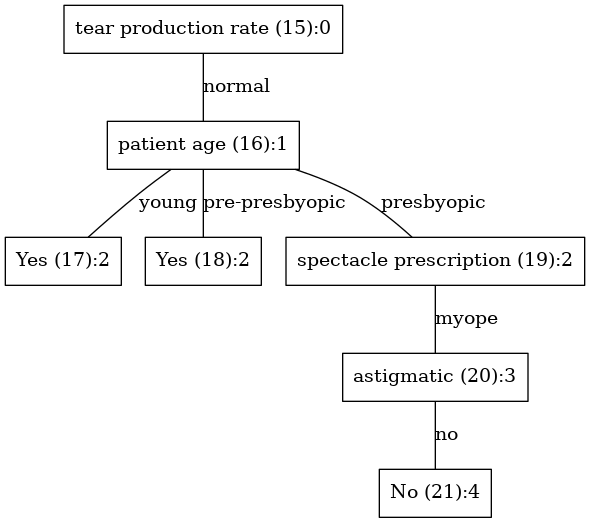

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


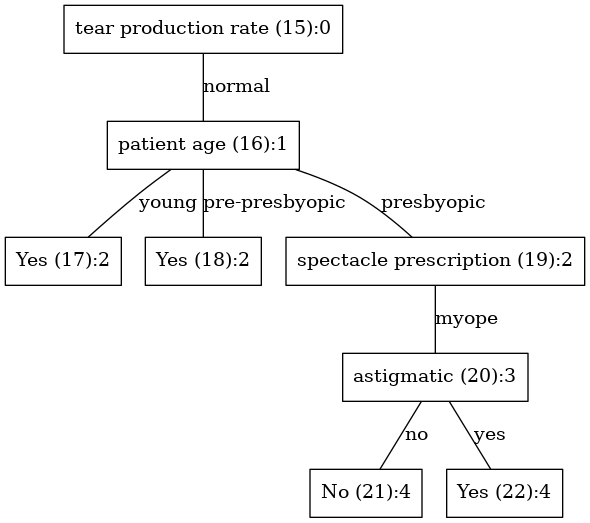

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


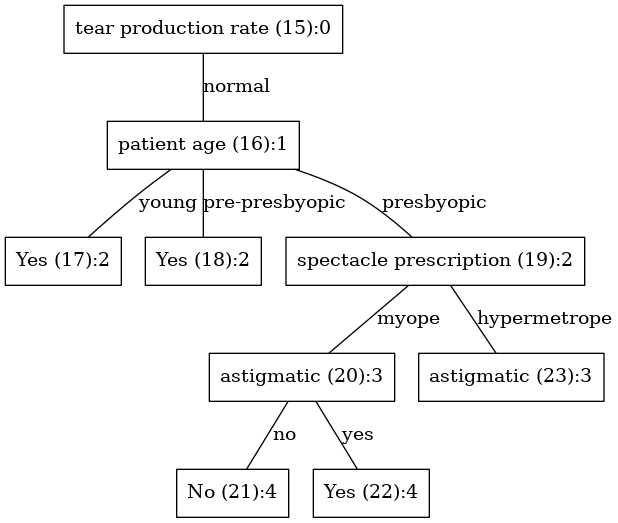

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


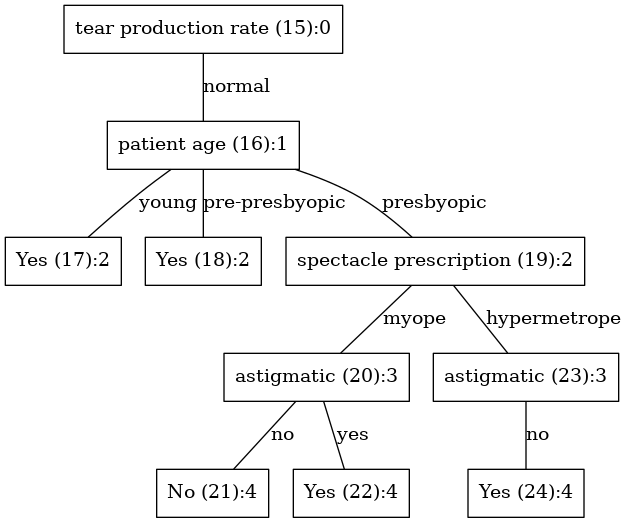

All classes same
ResultClass for child node of ' astigmatic ' =  No


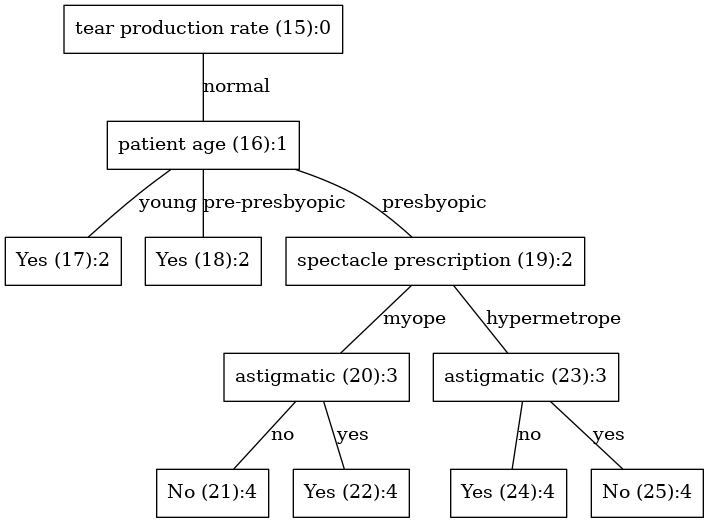

All classes same
ResultClass for child node of ' tear production rate ' =  No


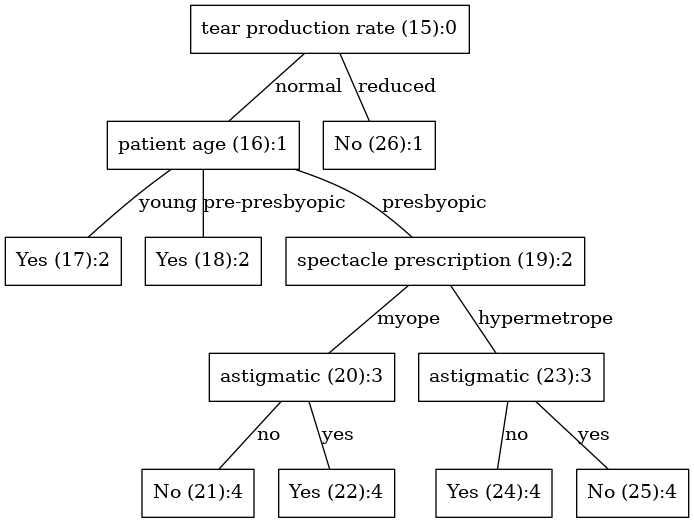

Confusion matrix, without normalization
[[3 1]
 [0 1]]
*****************************************FOLD 3 ************************************************

LEVEL 0  PARENT None
H(Class)=0.8997437586982626
H(Class|patient age='young')=1.0
H(Class|patient age='pre-presbyopic')=0.863120568566631
H(Class|patient age='presbyopic')=0.6500224216483541
Entropy(Class|patient age)=0.8390515005187653
Gain(Class|patient age)=0.060692258179497305
H(Class|spectacle prescription='myope')=0.9182958340544896
H(Class|spectacle prescription='hypermetrope')=0.8812908992306927
Entropy(Class|spectacle prescription)=0.8988195525682806
Gain(Class|spectacle prescription)=0.0009242061299820081
H(Class|astigmatic='no')=0.9182958340544896
H(Class|astigmatic='yes')=0.8812908992306927
Entropy(Class|astigmatic)=0.8988195525682806
Gain(Class|astigmatic)=0.0009242061299820081
H(Class|tear production rate='reduced')=0
H(Class|tear production rate='normal')=0.9182958340544896
Entropy(Class|tear production rate)=0.434982237

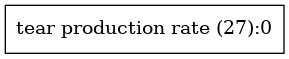

All classes same
ResultClass for child node of ' tear production rate ' =  No


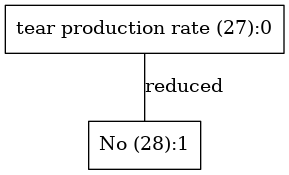

LEVEL 1  PARENT tear production rate
H(Class)=0.9182958340544896
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0.9182958340544896
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.612197222702993
Gain(Class|patient age)=0.3060986113514965
H(Class|spectacle prescription='myope')=0.8112781244591328
H(Class|spectacle prescription='hypermetrope')=0.9709505944546686
Entropy(Class|spectacle prescription)=0.8999850522344305
Gain(Class|spectacle prescription)=0.018310781820059074
H(Class|astigmatic='yes')=0.9709505944546686
H(Class|astigmatic='no')=0.8112781244591328
Entropy(Class|astigmatic)=0.8999850522344305
Gain(Class|astigmatic)=0.018310781820059074



Best Attribute for node of parent  tear production rate  for Level  1  is  patient age


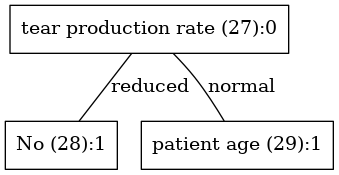

All classes same
ResultClass for child node of ' patient age ' =  Yes


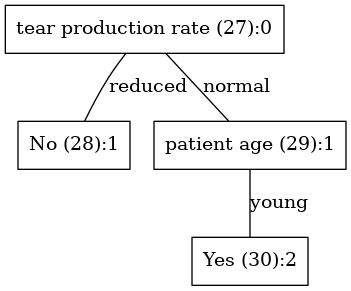

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=0.6666666666666666
Gain(Class|spectacle prescription)=0.2516291673878229
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=0.9182958340544896



Best Attribute for node of parent  patient age  for Level  2  is  astigmatic


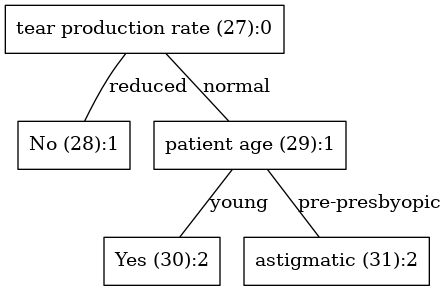

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


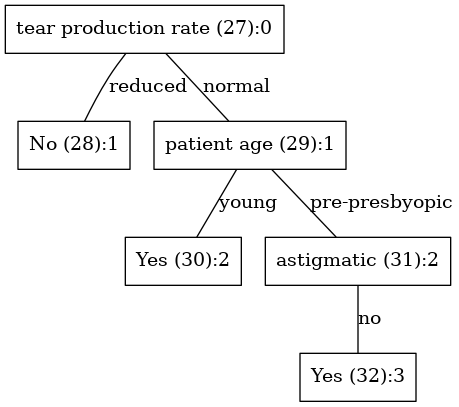

All classes same
ResultClass for child node of ' astigmatic ' =  No


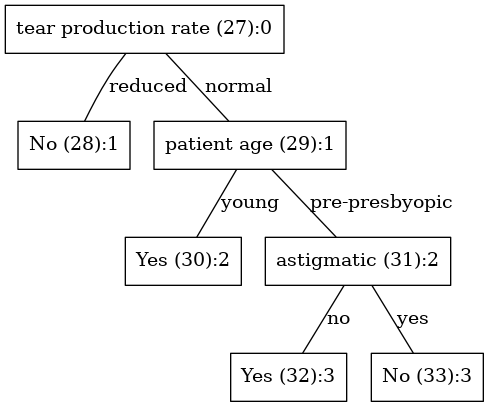

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=0
Entropy(Class|spectacle prescription)=0.6666666666666666
Gain(Class|spectacle prescription)=0.2516291673878229
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=1.0
Entropy(Class|astigmatic)=0.6666666666666666
Gain(Class|astigmatic)=0.2516291673878229



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


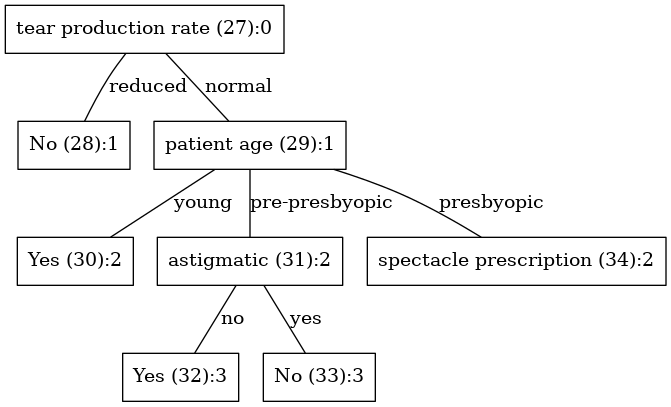

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


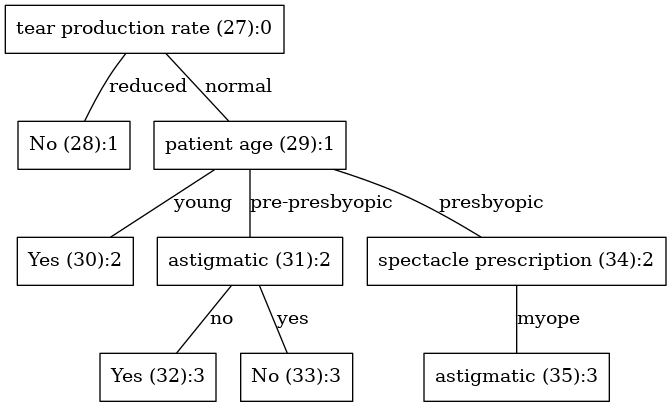

All classes same
ResultClass for child node of ' astigmatic ' =  No


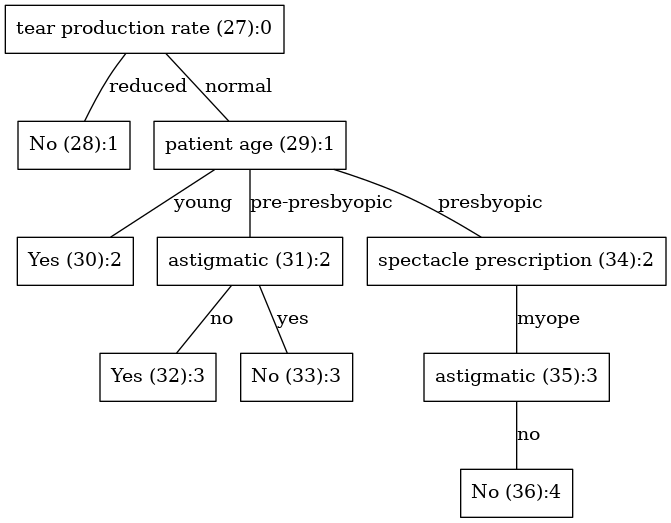

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


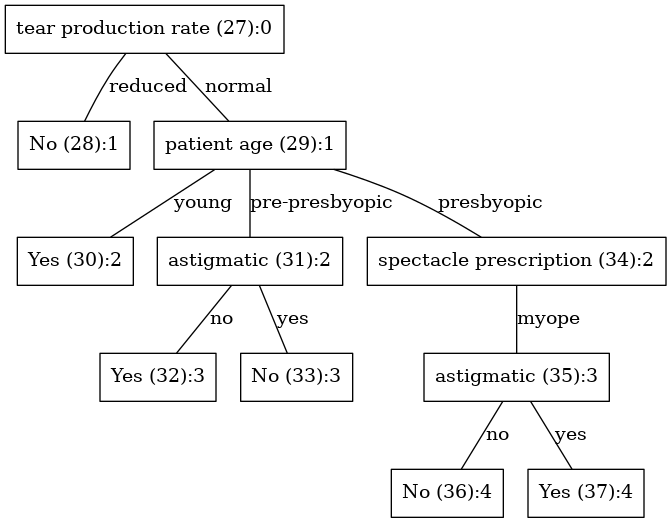

All classes same
ResultClass for child node of ' spectacle prescription ' =  No


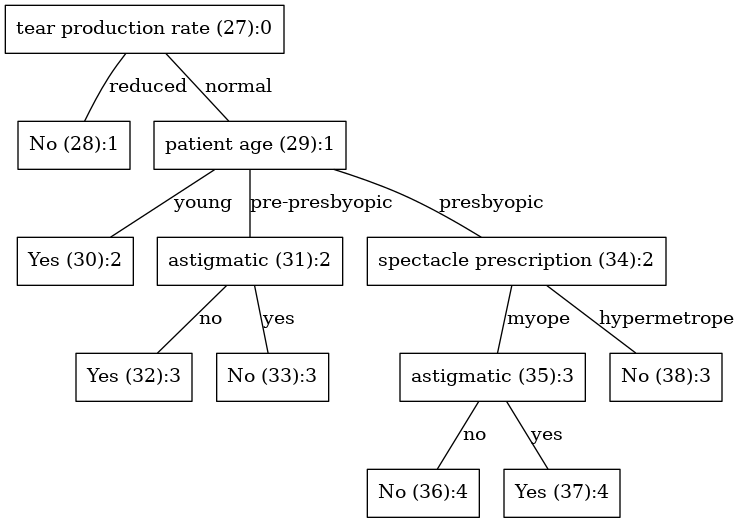

Confusion matrix, without normalization
[[2 0]
 [2 1]]
*****************************************FOLD 4 ************************************************

LEVEL 0  PARENT None
H(Class)=0.9819407868640976
H(Class|patient age='young')=1.0
H(Class|patient age='pre-presbyopic')=0.9852281360342515
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.9687564187666682
Gain(Class|patient age)=0.0131843680974294
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=0.9182958340544896
Entropy(Class|spectacle prescription)=0.9612980266573897
Gain(Class|spectacle prescription)=0.020642760206707855
H(Class|astigmatic='no')=1.0
H(Class|astigmatic='yes')=0.9182958340544896
Entropy(Class|astigmatic)=0.9612980266573897
Gain(Class|astigmatic)=0.020642760206707855
H(Class|tear production rate='reduced')=0
H(Class|tear production rate='normal')=0.7219280948873623
Entropy(Class|tear production rate)=0.3799621552038749
Gain(Class|tear productio

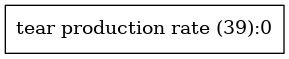

All classes same
ResultClass for child node of ' tear production rate ' =  No


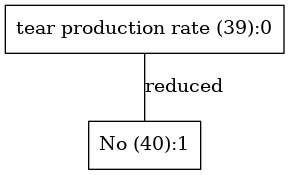

LEVEL 1  PARENT tear production rate
H(Class)=0.7219280948873623
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0.8112781244591328
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.6
Gain(Class|patient age)=0.12192809488736234
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=0.9709505944546686
Entropy(Class|spectacle prescription)=0.4854752972273343
Gain(Class|spectacle prescription)=0.23645279766002802
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0.9709505944546686
Entropy(Class|astigmatic)=0.4854752972273343
Gain(Class|astigmatic)=0.23645279766002802



Best Attribute for node of parent  tear production rate  for Level  1  is  spectacle prescription


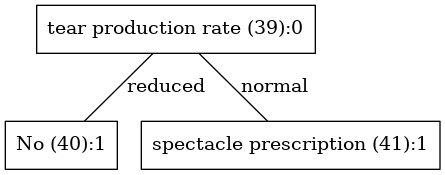

All classes same
ResultClass for child node of ' spectacle prescription ' =  Yes


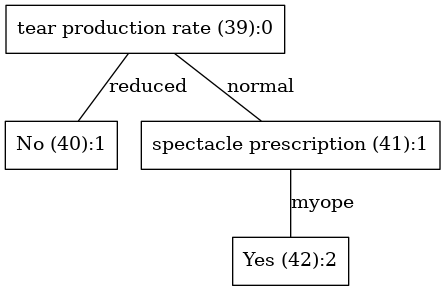

LEVEL 2  PARENT spectacle prescription
H(Class)=0.9709505944546686
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=1.0
H(Class|patient age='presbyopic')=1.0
Entropy(Class|patient age)=0.8
Gain(Class|patient age)=0.17095059445466854
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=0.9709505944546686



Best Attribute for node of parent  spectacle prescription  for Level  2  is  astigmatic


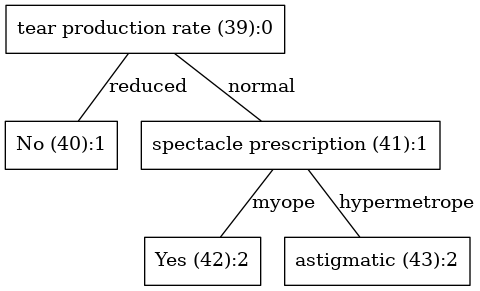

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


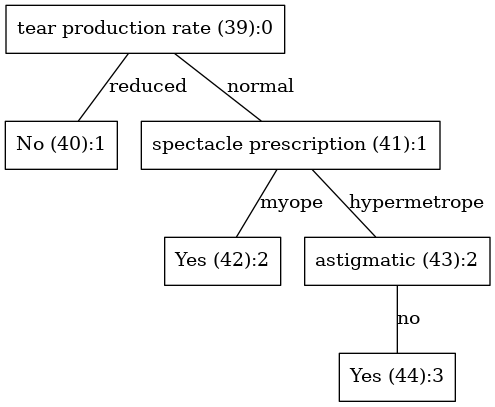

All classes same
ResultClass for child node of ' astigmatic ' =  No


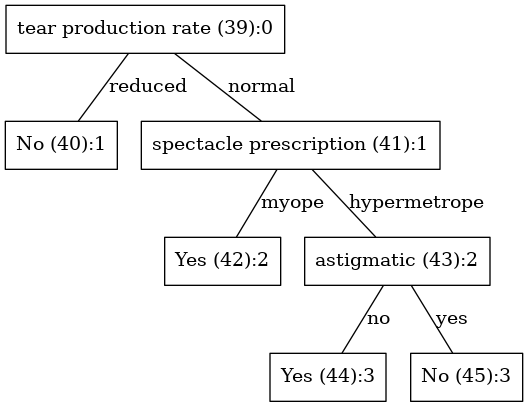

Confusion matrix, without normalization
[[3 1]
 [1 0]]
*****************************************FOLD 5 ************************************************

LEVEL 0  PARENT None
H(Class)=0.9494520153879484
H(Class|patient age='young')=0.9852281360342515
H(Class|patient age='pre-presbyopic')=0.9182958340544896
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.9429551032049281
Gain(Class|patient age)=0.006496912183020287
H(Class|spectacle prescription='myope')=0.9910760598382222
H(Class|spectacle prescription='hypermetrope')=0.8812908992306927
Entropy(Class|spectacle prescription)=0.9332943963605751
Gain(Class|spectacle prescription)=0.016157619027373338
H(Class|astigmatic='no')=0.9709505944546686
H(Class|astigmatic='yes')=0.9182958340544896
Entropy(Class|astigmatic)=0.9460088658440574
Gain(Class|astigmatic)=0.003443149543891022
H(Class|tear production rate='reduced')=0
H(Class|tear production rate='normal')=0.7642045065086203
Entropy(Class|tear production rat

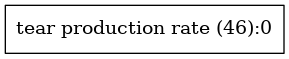

All classes same
ResultClass for child node of ' tear production rate ' =  No


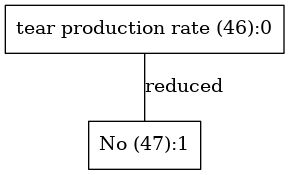

LEVEL 1  PARENT tear production rate
H(Class)=0.7642045065086203
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0.9182958340544896
H(Class|patient age='presbyopic')=0.9182958340544896
Entropy(Class|patient age)=0.612197222702993
Gain(Class|patient age)=0.15200728380562722
H(Class|spectacle prescription='myope')=0.7219280948873623
H(Class|spectacle prescription='hypermetrope')=0.8112781244591328
Entropy(Class|spectacle prescription)=0.7616392191414825
Gain(Class|spectacle prescription)=0.002565287367137792
H(Class|astigmatic='no')=0.7219280948873623
H(Class|astigmatic='yes')=0.8112781244591328
Entropy(Class|astigmatic)=0.7616392191414825
Gain(Class|astigmatic)=0.002565287367137792



Best Attribute for node of parent  tear production rate  for Level  1  is  patient age


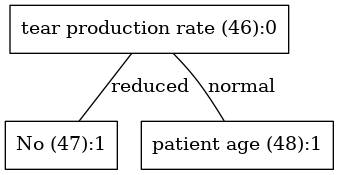

All classes same
ResultClass for child node of ' patient age ' =  Yes


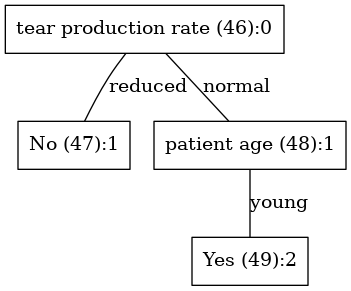

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=0
Entropy(Class|spectacle prescription)=0.0
Gain(Class|spectacle prescription)=0.9182958340544896
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=1.0
Entropy(Class|astigmatic)=0.6666666666666666
Gain(Class|astigmatic)=0.2516291673878229



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


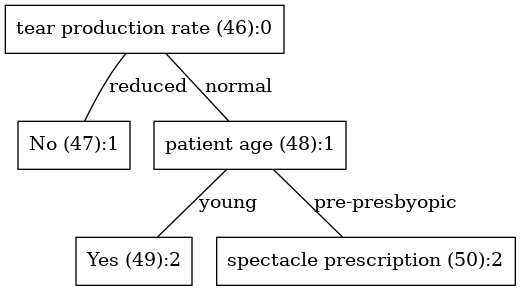

All classes same
ResultClass for child node of ' spectacle prescription ' =  Yes


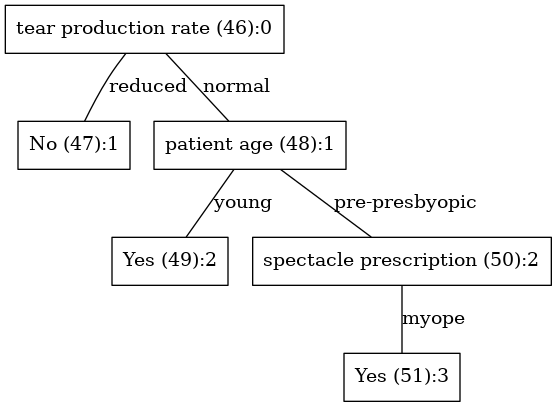

All classes same
ResultClass for child node of ' spectacle prescription ' =  No


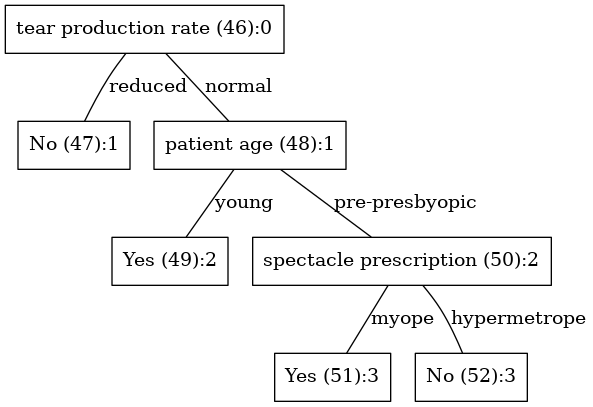

LEVEL 2  PARENT patient age
H(Class)=0.9182958340544896
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=0
Entropy(Class|spectacle prescription)=0.6666666666666666
Gain(Class|spectacle prescription)=0.2516291673878229
H(Class|astigmatic='no')=1.0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.6666666666666666
Gain(Class|astigmatic)=0.2516291673878229



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


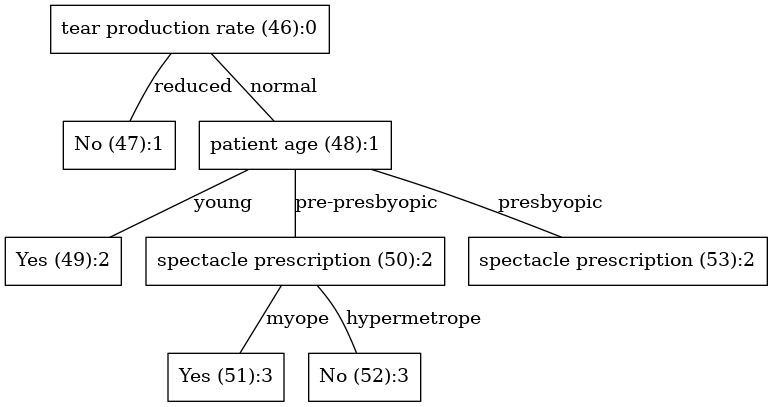

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


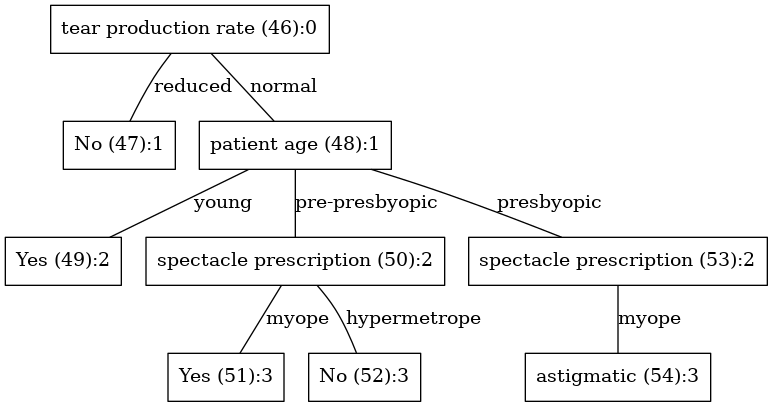

All classes same
ResultClass for child node of ' astigmatic ' =  No


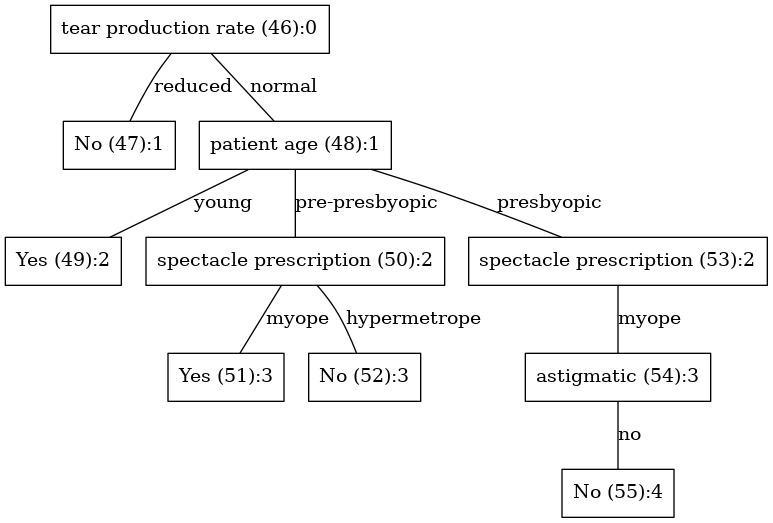

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


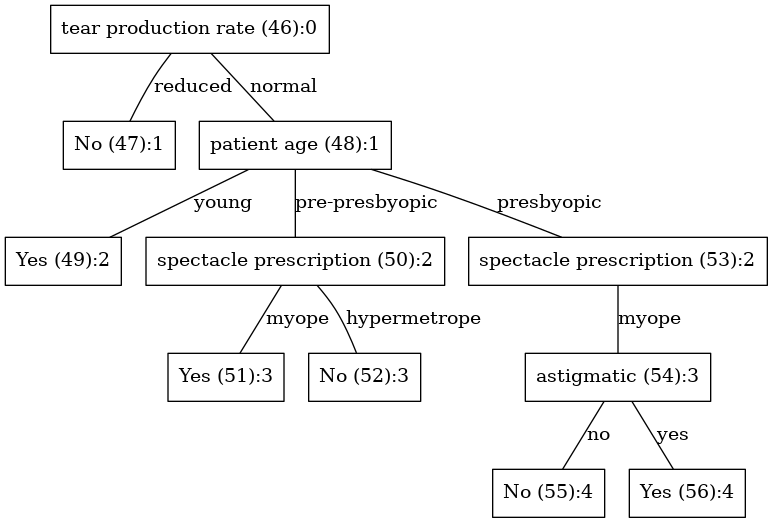

All classes same
ResultClass for child node of ' spectacle prescription ' =  Yes


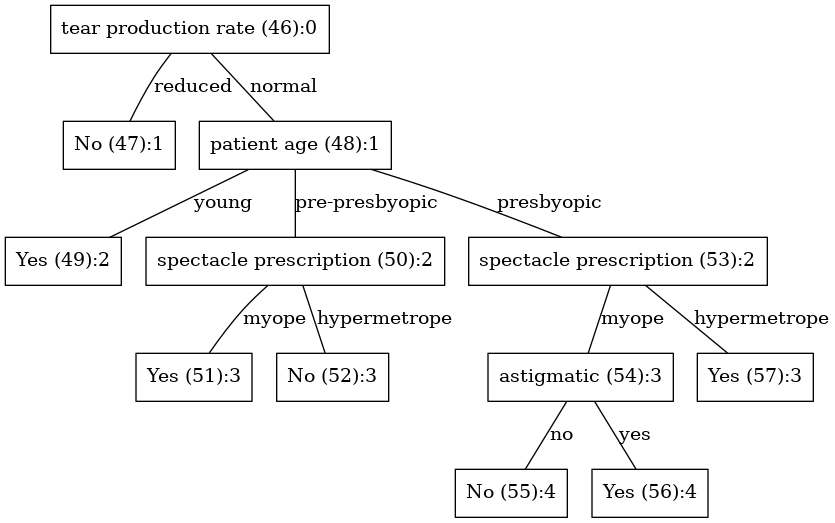

Confusion matrix, without normalization
[[2 1]
 [1 1]]
Average Accuracy over 5-folds= 0.67
Mean-squared error over 5-folds=  0.32999999999999996


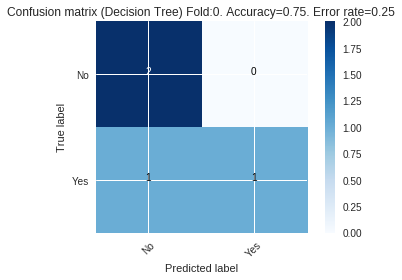

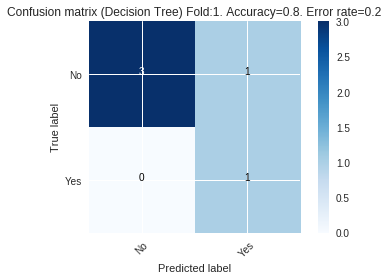

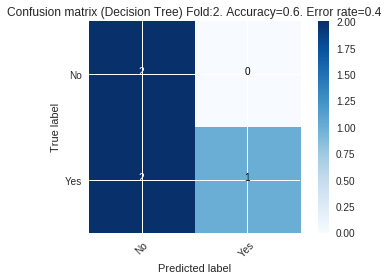

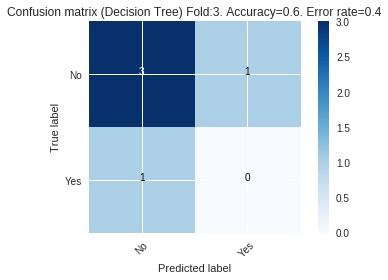

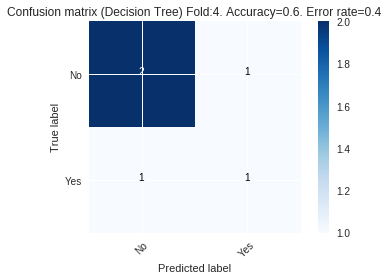

In [0]:
avgAccuracy=0
avgError=0
#for ith fold take id mod 5 == i-1 in the test set and 
#and others in train set
for k in range(0,5):
  print("*****************************************FOLD",str(k+1),"************************************************\n")
  test_data = df[df["Id"]%5==k]
  train_data = df[df["Id"]%5!=k]
  #Build tree from train set
  root = Node("root")
  treeRoot = TreeNode("root")
  buildTree(treeRoot,root,train_data,0)
  #Predict for new data points from test_set
  predictedClass = []
  for x in range(0,len(test_data)):
    predictedClass.append(predict(treeRoot,test_data.iloc[x]))
  #Create confusion matrix
  cnf_matrix = confusion_matrix(test_data.Class, predictedClass)
  plt.figure()
  #Calculate accuracy
  accuracy = accuracy_score(test_data.Class, predictedClass)        #Accuracy=(TN+TP)/Total
  error = (cnf_matrix[1][0]+cnf_matrix[0][1])/(len(test_data))      #Error=(FN+FP)/Total
  avgAccuracy = avgAccuracy + accuracy
  avgError = avgError + error
  plot_confusion_matrix(cnf_matrix, classes=["No","Yes"],title='Confusion matrix (Decision Tree) Fold:'+str(k)+'. Accuracy='+str(accuracy)+'. Error rate='+str(error))

print("Average Accuracy over 5-folds=",str(avgAccuracy/5))
print("Mean-squared error over 5-folds= ",str(avgError/5))

##Result: Average Accuracy: 0.8 and Average Error Rate: 0.2

#Naive-Bayes Classifier

##Train

In [0]:
#In the train function, we create a class-probabilities dictionary for 
#probability of attribute given class P(X|Class=i) for each attribute. 
'''
The dictionary will look like:
root:{
  class-label-1:{
    feature-1: ['value1':value,'value2':value,....]
    ....
    feature-n:['value1':value,'value2':value,....]
  },
  class-label-2:{
    feature-1: ['value1':value,'value2':value,....]
    ....
    feature-n:['value1':value,'value2':value,....]
  },
  ...
}

'''
def train(dataX,dataY):
  classes = dataY.unique()  #Class Labels
  probTableDict = {}        #Initialize Dictionary
  for c in classes:
    probTableDict[c] = defaultdict(list)
  #classProbs = calculateClassProbs(dataY)
  for c in classes:
    subsetData = dataX[dataY == c]   #Create a subset of dataset for class c
    count=0
    for x in dataX.columns:         #for each feature, create a list
      probTableDict[c][x] += list(subsetData.as_matrix()[:,count])
      count=count+1
  for c in classes:    #Assign each features and values in the list, probability
    for x in dataX.columns:
      probTableDict[c][x] = calculateClassProbs(probTableDict[c][x])
  return probTableDict
    
    
#Function to calculate class probabilities from a list/Series
#Get unique values by set and divide count by total to get prob
def calculateClassProbs(dataY):
  class_dict = dict(Counter(dataY))
  for x in list(set(dataY)):
    class_dict[x] = class_dict[x]/len(dataY)
  return class_dict
  

##Test

In [0]:
#Function to predict new datapoints by multiplying each feature probability and
#then multiply it with the class probability and compare P(X|No) > or < than
# P(X|Yes) and returning the bigger of the two
def predict(probDict,classProbs,row):
  finalClassProbs = {}
  for c in classProbs:
    classProb = classProbs[c]
    for f in row.keys():
      trainedProbs = probDict[c][f]
      if row[f] in trainedProbs:
        classProb *= trainedProbs[row[f]]
      else:
        classProb *= 0
    finalClassProbs[c] = classProb
    print("P("+c+"|X)= ",str(classProb))
    
  maxclass, maxprob = max(finalClassProbs.items(), key=operator.itemgetter(1))
  print("Maximum probability of the class for given record is of class :"+str(maxclass)+" with probability=",str(maxprob))
  return maxclass

##5-fold cross validation

*****************************************FOLD 1 ************************************************

{'No': defaultdict(<class 'list'>, {'patient age': {'young': 0.23076923076923078, 'pre-presbyopic': 0.3076923076923077, 'presbyopic': 0.46153846153846156}, 'spectacle prescription': {'myope': 0.5384615384615384, 'hypermetrope': 0.46153846153846156}, 'astigmatic': {'no': 0.46153846153846156, 'yes': 0.5384615384615384}, 'tear production rate': {'reduced': 0.7692307692307693, 'normal': 0.23076923076923078}}), 'Yes': defaultdict(<class 'list'>, {'patient age': {'young': 0.5714285714285714, 'pre-presbyopic': 0.2857142857142857, 'presbyopic': 0.14285714285714285}, 'spectacle prescription': {'myope': 0.42857142857142855, 'hypermetrope': 0.5714285714285714}, 'astigmatic': {'no': 0.5714285714285714, 'yes': 0.42857142857142855}, 'tear production rate': {'normal': 1.0}})}
P(No|X)=  0.024578971324533464
P(Yes|X)=  0.0
Maximum probability of the class for given record is of class :No with probability= 

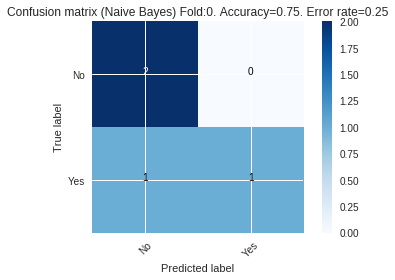

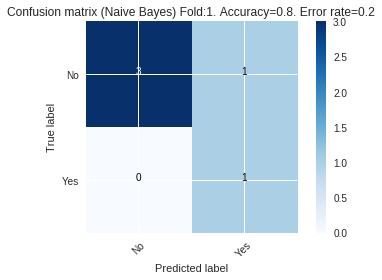

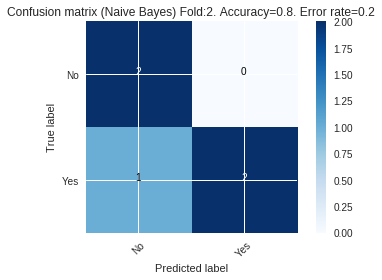

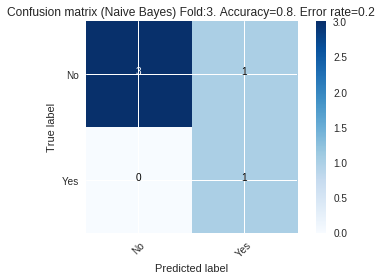

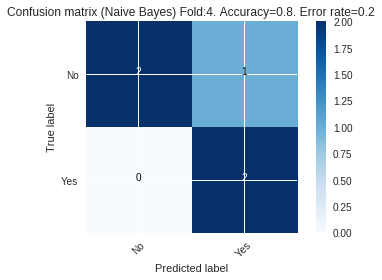

In [0]:
avgAccuracy=0
avgError=0
#for ith fold take id mod 5 == i-1 in the test set and 
#and others in train set
for k in range(0,5):
  print("*****************************************FOLD",str(k+1),"************************************************\n")
  test_data = df[df["Id"]%5==k]
  test_dataX = test_data.drop(columns=["Id","Class"])
  test_dataY = test_data["Class"]
  train_data = df[df["Id"]%5!=k]
  train_dataX = train_data.drop(columns=["Id","Class"])
  train_dataY = train_data["Class"]
  #train
  probDict = train(train_dataX,train_dataY)
  print(probDict)
  classProbs = calculateClassProbs(train_dataY)
  #predict
  predictedClass = []
  for x in range(0,len(test_data)):
    predictedClass.append(predict(probDict,classProbs,test_dataX.iloc[x]))
  #create confusion matrix
  cnf_matrix = confusion_matrix(test_dataY, predictedClass)
  plt.figure()
  #calulate accuracy and error
  accuracy = accuracy_score(test_dataY, predictedClass)    #accuracy=(TP+TN)/Total
  avgAccuracy = avgAccuracy + accuracy
  error = (cnf_matrix[1][0]+cnf_matrix[0][1])/(len(test_data))      #Error=(FN+FP)/Total
  avgError += error
  plot_confusion_matrix(cnf_matrix, classes=["No","Yes"],title='Confusion matrix (Naive Bayes) Fold:'+str(k)+'. Accuracy='+str(accuracy)+'. Error rate='+str(error))

print("Average Accuracy over 5-folds=",str(avgAccuracy/5))
print("Mean-squared error over 5-folds= ",str(avgError/5))

##Result: Average Accuracy: 0.79 and Average Error Rate 0.21

###(b) (5 points) Based on the 5-fold CV accuracy from (a), which classifier, NB or DT, would you choose? Report your final model for the selected classifier.

## Since, decision tree has a slightly higher accuracy, we will use it as our final model for the whole dataset. However, since there's very little difference between the accuracy and we had very less data 5 data points per test set per fold, the result could go either way if we had more data.

LEVEL 0  PARENT None
H(Class)=0.9544340029249649
H(Class|patient age='young')=1.0
H(Class|patient age='pre-presbyopic')=0.9544340029249649
H(Class|patient age='presbyopic')=0.8112781244591328
Entropy(Class|patient age)=0.9219040424613659
Gain(Class|patient age)=0.03252996046359902
H(Class|spectacle prescription='myope')=0.9798687566511528
H(Class|spectacle prescription='hypermetrope')=0.9182958340544896
Entropy(Class|spectacle prescription)=0.9490822953528212
Gain(Class|spectacle prescription)=0.00535170757214376
H(Class|astigmatic='no')=0.9798687566511528
H(Class|astigmatic='yes')=0.9182958340544896
Entropy(Class|astigmatic)=0.9490822953528212
Gain(Class|astigmatic)=0.00535170757214376
H(Class|tear production rate='reduced')=0
H(Class|tear production rate='normal')=0.8112781244591328
Entropy(Class|tear production rate)=0.4056390622295664
Gain(Class|tear production rate)=0.5487949406953985



Best Attribute for node of parent  None  for Level  0  is  tear production rate


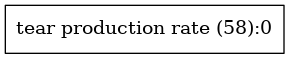

All classes same
ResultClass for child node of ' tear production rate ' =  No


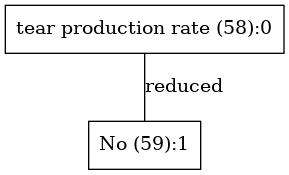

LEVEL 1  PARENT tear production rate
H(Class)=0.8112781244591328
H(Class|patient age='young')=0
H(Class|patient age='pre-presbyopic')=0.8112781244591328
H(Class|patient age='presbyopic')=1.0
Entropy(Class|patient age)=0.603759374819711
Gain(Class|patient age)=0.20751874963942185
H(Class|spectacle prescription='myope')=0.6500224216483541
H(Class|spectacle prescription='hypermetrope')=0.9182958340544896
Entropy(Class|spectacle prescription)=0.7841591278514218
Gain(Class|spectacle prescription)=0.027118996607711
H(Class|astigmatic='no')=0.6500224216483541
H(Class|astigmatic='yes')=0.9182958340544896
Entropy(Class|astigmatic)=0.7841591278514218
Gain(Class|astigmatic)=0.027118996607711



Best Attribute for node of parent  tear production rate  for Level  1  is  patient age


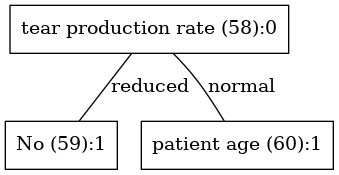

All classes same
ResultClass for child node of ' patient age ' =  Yes


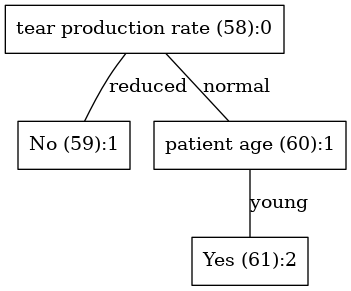

LEVEL 2  PARENT patient age
H(Class)=0.8112781244591328
H(Class|spectacle prescription='myope')=0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=0.5
Gain(Class|spectacle prescription)=0.31127812445913283
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=1.0
Entropy(Class|astigmatic)=0.5
Gain(Class|astigmatic)=0.31127812445913283



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


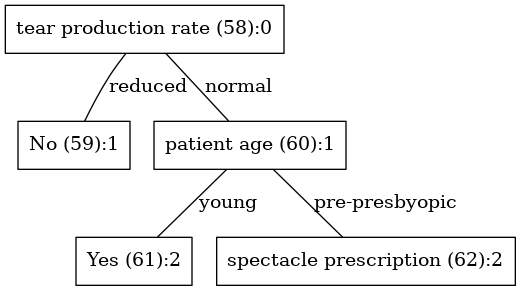

All classes same
ResultClass for child node of ' spectacle prescription ' =  Yes


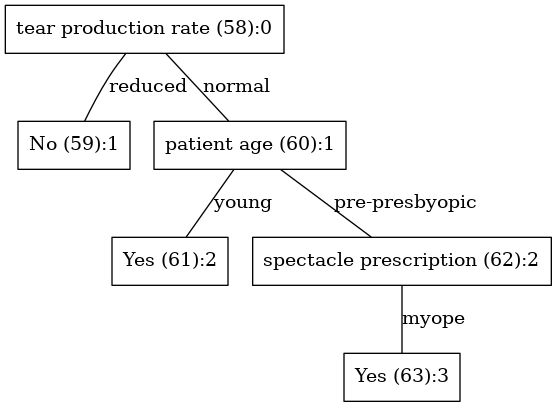

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


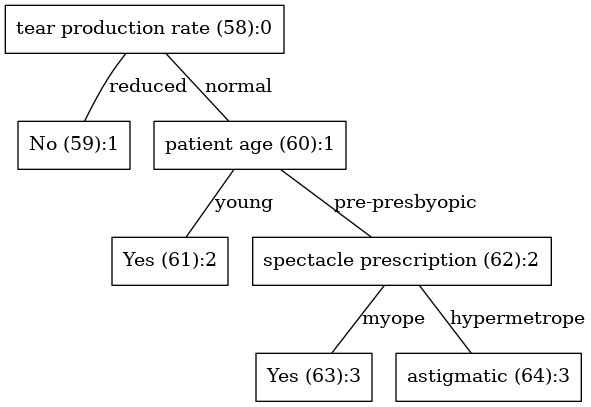

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


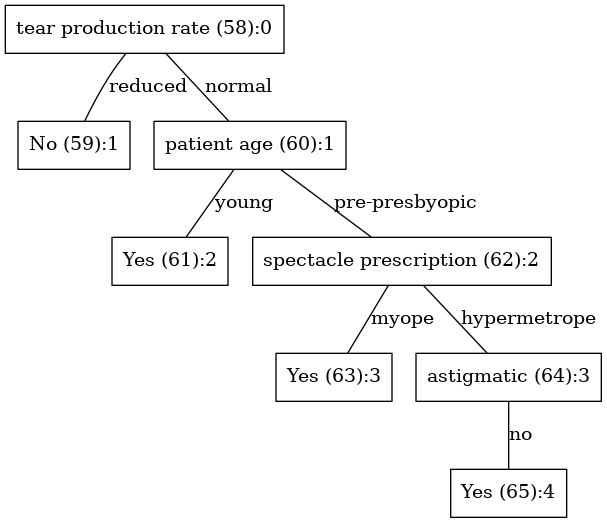

All classes same
ResultClass for child node of ' astigmatic ' =  No


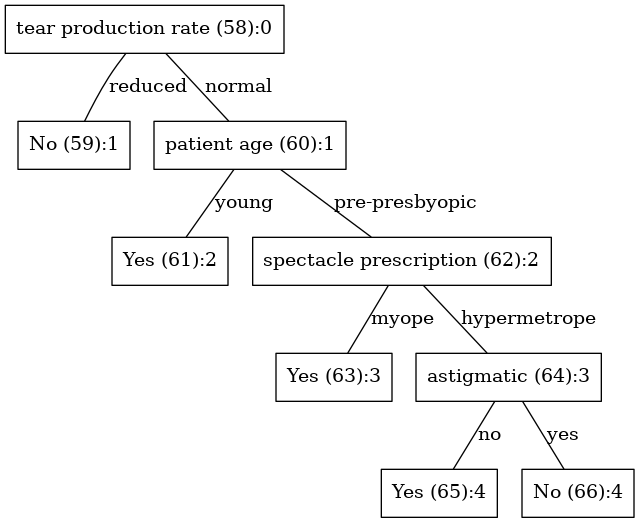

LEVEL 2  PARENT patient age
H(Class)=1.0
H(Class|spectacle prescription='myope')=1.0
H(Class|spectacle prescription='hypermetrope')=1.0
Entropy(Class|spectacle prescription)=1.0
Gain(Class|spectacle prescription)=0.0
H(Class|astigmatic='no')=1.0
H(Class|astigmatic='yes')=1.0
Entropy(Class|astigmatic)=1.0
Gain(Class|astigmatic)=0.0



Best Attribute for node of parent  patient age  for Level  2  is  spectacle prescription


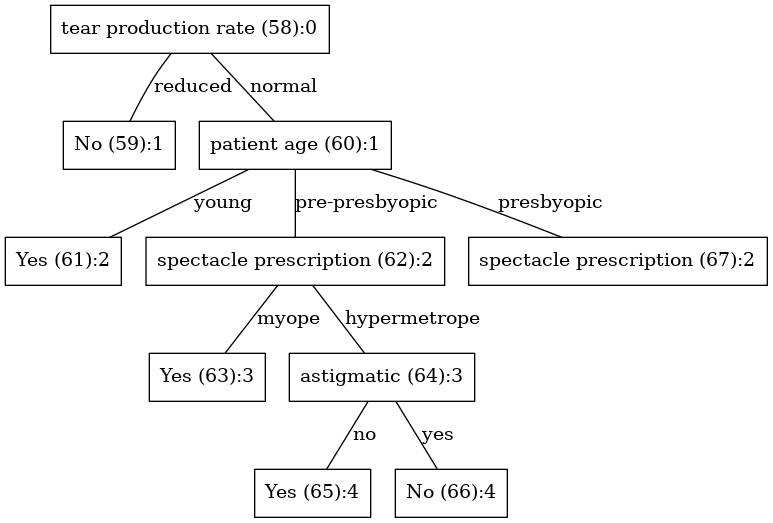

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


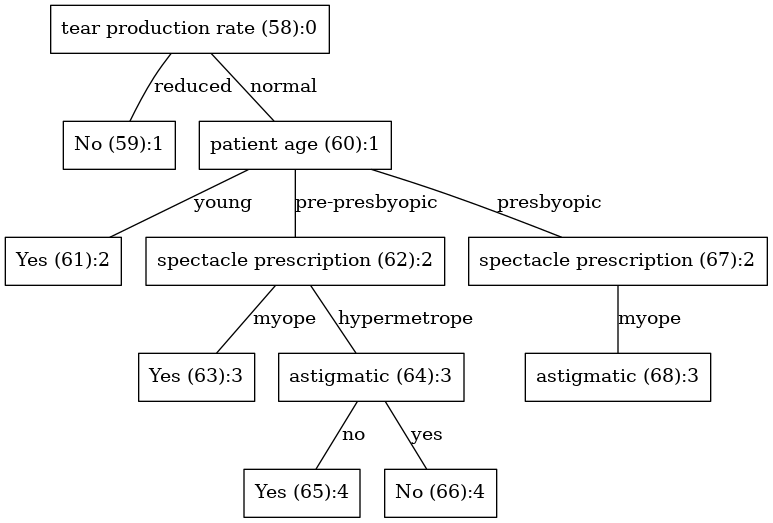

All classes same
ResultClass for child node of ' astigmatic ' =  No


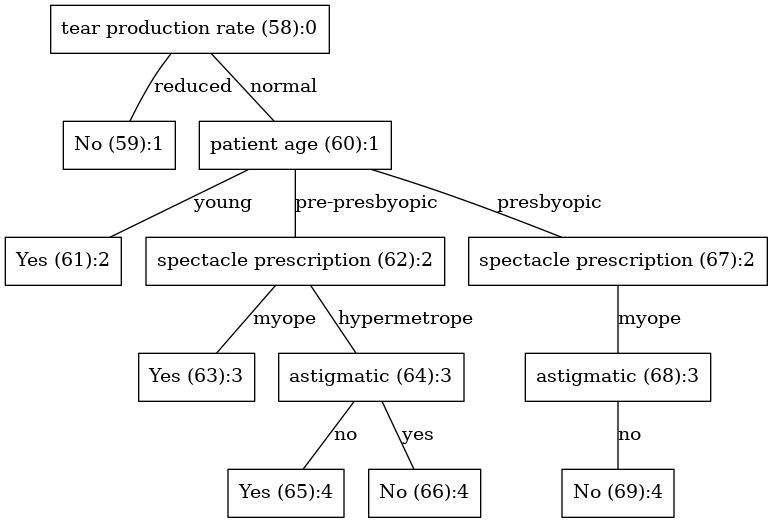

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


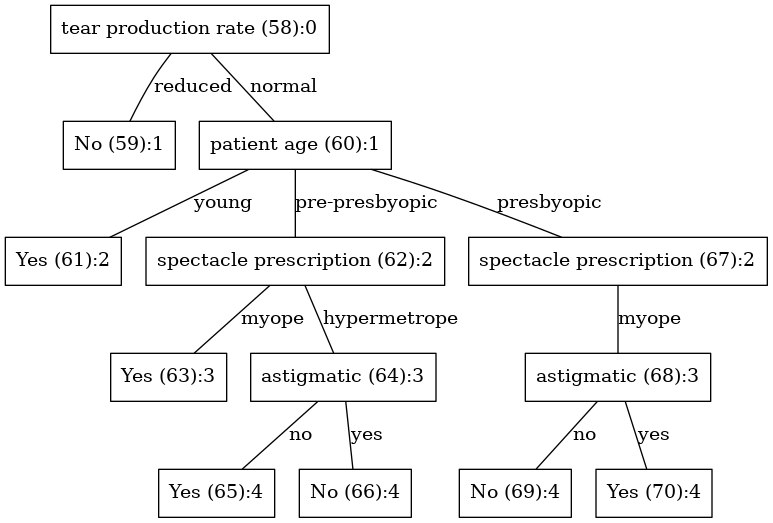

LEVEL 3  PARENT spectacle prescription
H(Class)=1.0
H(Class|astigmatic='no')=0
H(Class|astigmatic='yes')=0
Entropy(Class|astigmatic)=0.0
Gain(Class|astigmatic)=1.0



Best Attribute for node of parent  spectacle prescription  for Level  3  is  astigmatic


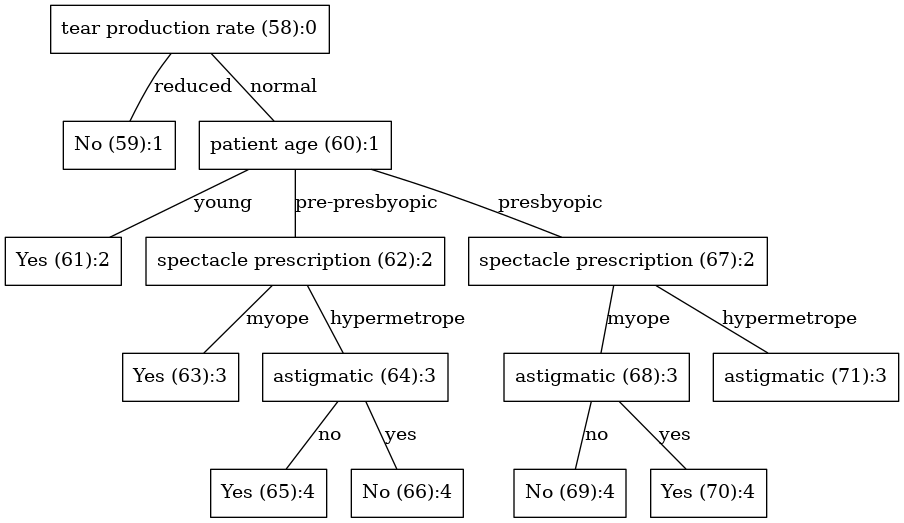

All classes same
ResultClass for child node of ' astigmatic ' =  Yes


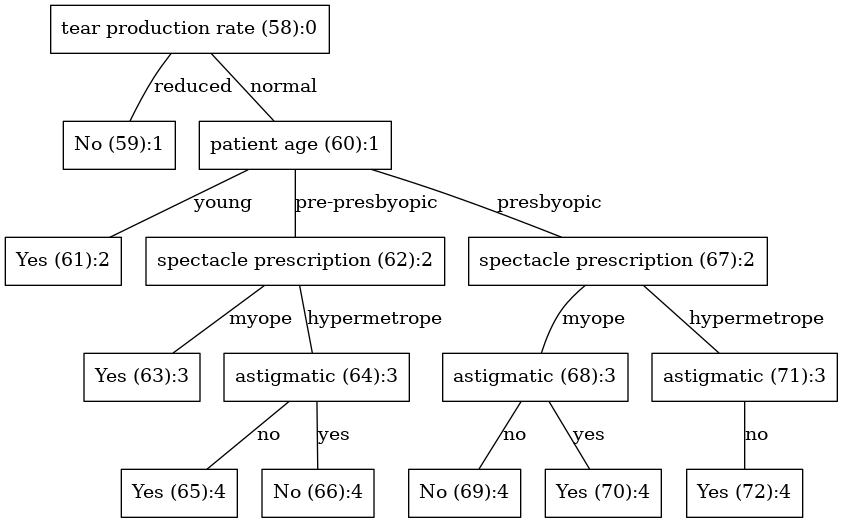

All classes same
ResultClass for child node of ' astigmatic ' =  No


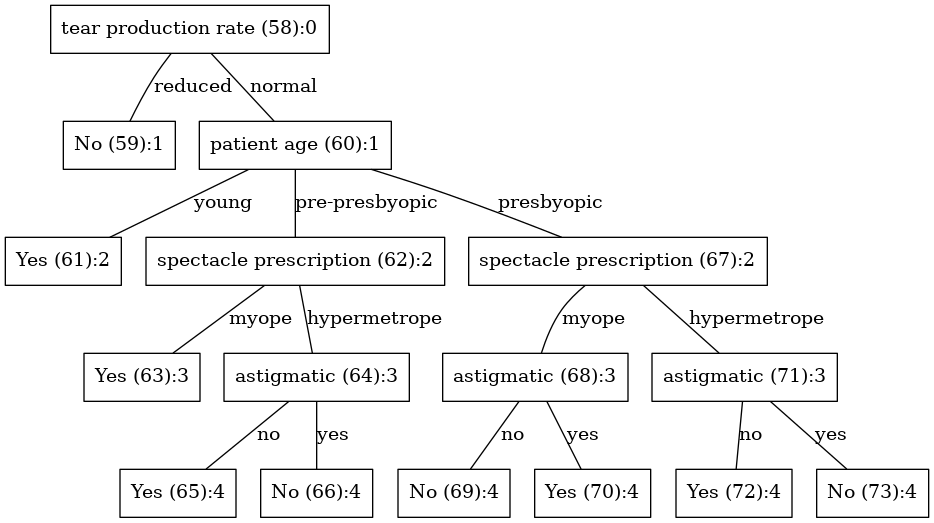

In [0]:
root = Node("root")
treeRoot = TreeNode("root")
buildTree(treeRoot,root,df,0)